In [1]:
# Setting the environment variables

In [2]:
import os
import sys
os.environ["PYSPARK_PYTHON"]="/usr/bin/python3"
os.environ["PYSPARK_DRIVER_PYTHON"]="/usr/bin/python3"
os.environ["PYSPARK_DRIVER_PYTHON_OPTS"]="notebook --no-browser"
os.environ["JAVA_HOME"] = "/usr/java/jdk1.8.0_161/jre"
os.environ["SPARK_HOME"] = "/home/ec2-user/spark-2.4.4-bin-hadoop2.7"
os.environ["PYLIB"] = os.environ["SPARK_HOME"] + "/python/lib"
sys.path.insert(0, os.environ["PYLIB"] + "/py4j-0.10.7-src.zip")
sys.path.insert(0, os.environ["PYLIB"] + "/pyspark.zip")

# Ecommerce Churn Assignment

The aim of the assignment is to build a model that predicts whether a person purchases an item after it has been added to the cart or not. Being a classification problem, you are expected to use your understanding of all the three models covered till now. You must select the most robust model and provide a solution that predicts the churn in the most suitable manner. 

For this assignment, you are provided the data associated with an e-commerce company for the month of October 2019. Your task is to first analyse the data, and then perform multiple steps towards the model building process.

The broad tasks are:
- Data Exploration
- Feature Engineering
- Model Selection
- Model Inference

### Data description

The dataset stores the information of a customer session on the e-commerce platform. It records the activity and the associated parameters with it.

- **event_time**: Date and time when user accesses the platform
- **event_type**: Action performed by the customer
            - View
            - Cart
            - Purchase
            - Remove from cart
- **product_id**: Unique number to identify the product in the event
- **category_id**: Unique number to identify the category of the product
- **category_code**: Stores primary and secondary categories of the product
- **brand**: Brand associated with the product
- **price**: Price of the product
- **user_id**: Unique ID for a customer
- **user_session**: Session ID for a user


### Initialising the SparkSession

The dataset provided is 5 GBs in size. Therefore, it is expected that you increase the driver memory to a greater number. You can refer to notebook 1 for the steps involved here.

In [3]:
# Spark environment
from pyspark import SparkConf
from pyspark.sql import SparkSession

In [4]:
# initialising the session with 14 GB driver memory
MAX_MEMORY = "14G"

spark = SparkSession \
    .builder \
    .appName("demo") \
    .config("spark.driver.memory", MAX_MEMORY) \
    .getOrCreate()

spark

In [5]:
## loading clean data
df  = spark.read.parquet('cleaned_df.parquet')

In [6]:
df.show(20)

+-------+-----------+-----------+----------+-------------+----------------+-------------+----------------------------+--------------+--------+-------------+------------+
|  price|day_of_week|   main_cat|   sub_cat|user_activity|product_affinity|sub_cat_views|avg_shopping_expense_per_cat|session_counts|hour_bin|brand_reduced|is_Purchased|
+-------+-----------+-----------+----------+-------------+----------------+-------------+----------------------------+--------------+--------+-------------+------------+
| 755.49|          1|electronics|smartphone|            3|               5|            6|                         0.0|             2|       2|        apple|           0|
| 558.03|          5| appliances|   kitchen|            2|               1|           16|                         0.0|             8|       3|        Other|           0|
| 545.63|          6|electronics|smartphone|            2|               1|            1|                         0.0|             1|       3|      sa

In [7]:
df.printSchema()

root
 |-- price: double (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- main_cat: string (nullable = true)
 |-- sub_cat: string (nullable = true)
 |-- user_activity: long (nullable = true)
 |-- product_affinity: long (nullable = true)
 |-- sub_cat_views: long (nullable = true)
 |-- avg_shopping_expense_per_cat: double (nullable = true)
 |-- session_counts: long (nullable = true)
 |-- hour_bin: integer (nullable = true)
 |-- brand_reduced: string (nullable = true)
 |-- is_Purchased: integer (nullable = true)



In [8]:
from pyspark.sql.functions import countDistinct
categ_col = ['main_cat','sub_cat','brand_reduced']
df.agg(*[countDistinct(c) for c in categ_col]).show()

+------------------------+-----------------------+-----------------------------+
|count(DISTINCT main_cat)|count(DISTINCT sub_cat)|count(DISTINCT brand_reduced)|
+------------------------+-----------------------+-----------------------------+
|                      13|                     38|                           20|
+------------------------+-----------------------+-----------------------------+



<hr>

## Task 3: Model Selection
3 models for classification:	
- Logistic Regression
- Decision Tree
- Random Forest

### Model 1: Logistic Regression

In [9]:
df.columns

['price',
 'day_of_week',
 'main_cat',
 'sub_cat',
 'user_activity',
 'product_affinity',
 'sub_cat_views',
 'avg_shopping_expense_per_cat',
 'session_counts',
 'hour_bin',
 'brand_reduced',
 'is_Purchased']

In [10]:
# Additional steps for Logistic regression - Feature selection, Correlation, etc.
num_feature_cols = ['price',
 'day_of_week',
 'user_activity',
 'product_affinity',
 'sub_cat_views',
 'avg_shopping_expense_per_cat',
 'session_counts',
 'hour_bin']
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=num_feature_cols, outputCol=vector_col)
df_vector = assembler.transform(df).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col)

    

In [11]:
import pandas as pd

In [12]:
cor_matrix = pd.DataFrame(matrix.collect()[0]["pearson({})".format(vector_col)].values.reshape(8,8),columns=num_feature_cols)
cor_matrix['cols'] = num_feature_cols
cor_matrix.set_index('cols',inplace=True)

In [13]:
cor_matrix

,price,day_of_week,user_activity,product_affinity,sub_cat_views,avg_shopping_expense_per_cat,session_counts,hour_bin
cols,,,,,,,,
price,1.000000,0.001539,-0.059865,0.024020,0.026532,0.399999,0.051099,0.036779
day_of_week,0.001539,1.000000,-0.001285,-0.004189,-0.007383,-0.008033,-0.012001,0.001437
user_activity,-0.059865,-0.001285,1.000000,0.109441,0.230759,-0.015072,0.008443,0.043661
product_affinity,0.024020,-0.004189,0.109441,1.000000,0.549332,0.175337,0.500828,-0.016350
sub_cat_views,0.026532,-0.007383,0.230759,0.549332,1.000000,0.184410,0.699351,0.002704
avg_shopping_expense_per_cat,0.399999,-0.008033,-0.015072,0.175337,0.184410,1.000000,0.226792,-0.004401
session_counts,0.051099,-0.012001,0.008443,0.500828,0.699351,0.226792,1.000000,-0.006888
hour_bin,0.036779,0.001437,0.043661,-0.016350,0.002704,-0.004401,-0.006888,1.000000


There are some strong correlations:

1) sub_cat_views with session_counts - 0.699351

2) product_affinity with sub_cat_views - 0.549332

3) product_affinity with session_counts - 0.500828

4) Price with avg_shopping_expense_per_cat - 0.399999

avg_shopping_expense_per_cat is user behaviour based and price is product based. Both are important. Keep them for now.
will reevaluate in case of unstable model

removing session_counts and sub_cat_views for first model

In [14]:
features = ['price',
 'day_of_week',
 'main_cat',
 'sub_cat',
 'user_activity',
 'product_affinity',
 'avg_shopping_expense_per_cat',
 'hour_bin',
 'brand_reduced']

#### Feature Transformation

In [15]:
# Check if only the required columns are present to build the model
# If not, drop the redundant columns


In [16]:
# Categorising the attributes into its type - Continuous and Categorical
categ_cols = ['main_cat','sub_cat','brand_reduced']
num_categ_cols = ['day_of_week','hour_bin']
num_cols  =  ['price',
 'user_activity',
 'product_affinity',
 'avg_shopping_expense_per_cat']

In [17]:
# Feature transformation for categorical features
stages = []
from pyspark.ml.feature import StringIndexer
for c in categ_cols:   
    si = StringIndexer(inputCol=c,outputCol=c+'_ix')
    stages.append(si)

In [18]:
from pyspark.ml.feature import OneHotEncoderEstimator
cols_to_encode = num_categ_cols + [c+'_ix' for c in categ_cols]
encoded_cols = [c+'_enc' for c in num_categ_cols] + [c+'_enc' for c in categ_cols]
ohe = OneHotEncoderEstimator(inputCols =cols_to_encode, outputCols = encoded_cols)
stages.append(ohe)

In [19]:
## updating features
features = num_cols + encoded_cols

In [20]:
# Vector assembler to combine all the features
from pyspark.ml.feature import VectorAssembler,StandardScaler
assembler = VectorAssembler(inputCols=features,outputCol='features')
scaler = StandardScaler(inputCol='features',outputCol='scaled_features')

In [21]:
stages.append(assembler)
stages.append(scaler)

In [22]:
stages

[StringIndexer_ad88b4fbfe2c,
 StringIndexer_1b6cacae1ad4,
 StringIndexer_558730643be9,
 OneHotEncoderEstimator_322c93d38025,
 VectorAssembler_928a2627a277,
 StandardScaler_1f7d38cad843]

In [23]:
# Pipeline for the tasks
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=stages)

In [24]:
# Transforming the dataframe df
df = pipeline.fit(df).transform(df)

In [25]:
# Schema of the transformed df
df.printSchema()

root
 |-- price: double (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- main_cat: string (nullable = true)
 |-- sub_cat: string (nullable = true)
 |-- user_activity: long (nullable = true)
 |-- product_affinity: long (nullable = true)
 |-- sub_cat_views: long (nullable = true)
 |-- avg_shopping_expense_per_cat: double (nullable = true)
 |-- session_counts: long (nullable = true)
 |-- hour_bin: integer (nullable = true)
 |-- brand_reduced: string (nullable = true)
 |-- is_Purchased: integer (nullable = true)
 |-- main_cat_ix: double (nullable = false)
 |-- sub_cat_ix: double (nullable = false)
 |-- brand_reduced_ix: double (nullable = false)
 |-- brand_reduced_enc: vector (nullable = true)
 |-- hour_bin_enc: vector (nullable = true)
 |-- main_cat_enc: vector (nullable = true)
 |-- sub_cat_enc: vector (nullable = true)
 |-- day_of_week_enc: vector (nullable = true)
 |-- features: vector (nullable = true)
 |-- scaled_features: vector (nullable = true)



In [26]:
# Checking the elements of the transformed df - Top 20 rows
df = df.drop(*['main_cat_ix','sub_cat_ix','brand_reduced_ix'])
df.show(20)

+-------+-----------+-----------+----------+-------------+----------------+-------------+----------------------------+--------------+--------+-------------+------------+-----------------+-------------+--------------+--------------+---------------+--------------------+--------------------+
|  price|day_of_week|   main_cat|   sub_cat|user_activity|product_affinity|sub_cat_views|avg_shopping_expense_per_cat|session_counts|hour_bin|brand_reduced|is_Purchased|brand_reduced_enc| hour_bin_enc|  main_cat_enc|   sub_cat_enc|day_of_week_enc|            features|     scaled_features|
+-------+-----------+-----------+----------+-------------+----------------+-------------+----------------------------+--------------+--------+-------------+------------+-----------------+-------------+--------------+--------------+---------------+--------------------+--------------------+
| 755.49|          1|electronics|smartphone|            3|               5|            6|                         0.0|            

In [27]:
# Storing the transformed df in S3 bucket to prevent repetition of steps again


#### Train-test split

In [28]:
df.groupby('is_Purchased').count().show()

+------------+------+
|is_Purchased| count|
+------------+------+
|           1|486047|
|           0|298314|
+------------+------+



In [29]:
# Splitting the data into train and test (Remember you are expected to compare the model later)
# since imbalanced distribution, split dfs based on label value
from pyspark.sql.functions import col
df_0 = df.filter(col('is_Purchased')== 0)
df_1 = df.filter(col('is_Purchased')== 1)
train_0,test_0 = df_0.randomSplit([0.7,0.3],seed=42)
train_1,test_1 = df_1.randomSplit([0.7,0.3],seed=42)
train_df = train_0.union(train_1)
test_df = test_0.union(test_1)

In [30]:
# Number of rows in train and test data
train_df.count()

549880

In [31]:
test_df.count()

234481

#### Model Fitting

In [32]:
# Building the model
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol='scaled_features',labelCol='is_Purchased')

In [33]:
# Fitting the model on transformed df
model = lr.fit(train_df)

In [34]:
trainingsummary = model.summary

In [35]:
trainingsummary.areaUnderROC

0.70130210319589

In [36]:
fpr = trainingsummary.roc.select('FPR').collect()
tpr = trainingsummary.roc.select('TPR').collect()

In [37]:
import matplotlib.pyplot as plt

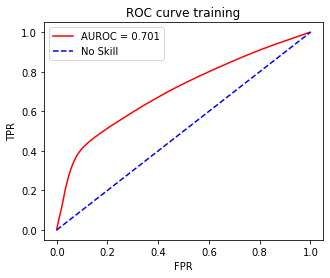

In [38]:
plt.figure(figsize=(5,4))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot(fpr,tpr,color='r',label=f'AUROC = {round(trainingsummary.areaUnderROC,3)}')
plt.plot(fpr,fpr,'b--',label=f'No Skill')
plt.legend()
plt.plot
plt.title('ROC curve training')
plt.show()

#### Model Analysis

Required Steps:
- Fit on test data
- Performance analysis
    - Appropriate Metric with reasoning
    - Threshold selection

In [39]:
# For getting the best threshold for the model, fmeasure is being maximized. 

In [40]:
# Set the model threshold to maximize F-Measure
fMeasure = trainingsummary.fMeasureByThreshold
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()
bestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
    .select('threshold').head()['threshold']

In [41]:
bestThreshold

0.30136065945667695

In [42]:
trainpred = model.transform(train_df)

In [43]:
testpred = model.transform(test_df)

In [44]:
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType
getProb = udf(lambda x: float(x[1]),FloatType())
trainpred = trainpred.withColumn('prob_purchased',getProb(col('probability')))
testpred = testpred.withColumn('prob_purchased',getProb(col('probability')))

In [45]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.mllib.evaluation import MulticlassMetrics

# AUC ROC for test set
testpreds = testpred.select('is_Purchased','prob_purchased').rdd.map(lambda row: (float(row['prob_purchased']), float(row['is_Purchased'])))
b_metrics = BinaryClassificationMetrics(testpreds)
print('AUROC test is ',round(b_metrics.areaUnderROC,3))

AUROC test is  0.701


In [46]:
predAndLabelstrain = trainpred.select('prediction','is_Purchased').rdd.map(lambda row: (float(row['prediction']), float(row['is_Purchased'])))
predAndLabelstest = testpred.select('prediction','is_Purchased').rdd.map(lambda row: (float(row['prediction']), float(row['is_Purchased'])))
trainMetrics = MulticlassMetrics(predAndLabelstrain)
testMetrics = MulticlassMetrics(predAndLabelstest)

In [47]:
print('Precision Comaprison')
print(f'Train : {trainMetrics.precision(1.0)}')
print(f'Test : {testMetrics.precision(1.0)}')

Precision Comaprison
Train : 0.6718563071676856
Test : 0.6727275735415771


In [48]:
print('Recall Comaprison')
print(f'Train : {trainMetrics.recall(1.0)}')
print(f'Test : {testMetrics.recall(1.0)}')

Recall Comaprison
Train : 0.8377818041928882
Test : 0.838267430833299


In [49]:
print('fMeasure Comaprison')
print(f'Train : {trainMetrics.fMeasure(1.0)}')
print(f'Test : {testMetrics.fMeasure(1.0)}')

fMeasure Comaprison
Train : 0.7457005555722551
Test : 0.7464294892976466


In [50]:
print('Confusion Matrix')
print(f'Train :\n {trainMetrics.confusionMatrix().toArray()}')
print(f'Test : \n{testMetrics.confusionMatrix().toArray()}')

Confusion Matrix
Train :
 [[ 70012. 139339.]
 [ 55240. 285289.]]
Test : 
[[ 29620.  59343.]
 [ 23535. 121983.]]


In [51]:
## tuning using the best threshold based on fMeasure
from pyspark.sql.functions import when,col
trainpred = trainpred.withColumn('tunedPrediction',when(col('prob_purchased')>=bestThreshold,1.0).otherwise(0.0))
testpred = testpred.withColumn('tunedPrediction',when(col('prob_purchased')>=bestThreshold,1.0).otherwise(0.0))

In [52]:
predAndLabelstrain = trainpred.select('tunedPrediction','is_Purchased').rdd.map(lambda row: (float(row['tunedPrediction']), float(row['is_Purchased'])))
predAndLabelstest = testpred.select('tunedPrediction','is_Purchased').rdd.map(lambda row: (float(row['tunedPrediction']), float(row['is_Purchased'])))
trainMetrics = MulticlassMetrics(predAndLabelstrain)
testMetrics = MulticlassMetrics(predAndLabelstest)

In [53]:
print('Precision Comaprison')
print(f'Train : {trainMetrics.precision(1.0)}')
print(f'Test : {testMetrics.precision(1.0)}')

Precision Comaprison
Train : 0.6203034081842431
Test : 0.6216215058920253


In [54]:
print('Recall Comaprison')
print(f'Train : {trainMetrics.recall(1.0)}')
print(f'Test : {testMetrics.recall(1.0)}')

Recall Comaprison
Train : 0.9977035729702903
Test : 0.9976154152750862


In [55]:
print('fMeasure Comaprison')
print(f'Train : {trainMetrics.fMeasure(1.0)}')
print(f'Test : {testMetrics.fMeasure(1.0)}')

fMeasure Comaprison
Train : 0.7649891921102404
Test : 0.7659647438095892


In [56]:
print('Confusion Matrix')
print(f'Train :\n {trainMetrics.confusionMatrix().toArray()}')
print(f'Test : \n{testMetrics.confusionMatrix().toArray()}')

Confusion Matrix
Train :
 [[  1387. 207964.]
 [   782. 339747.]]
Test : 
[[   598.  88365.]
 [   347. 145171.]]


### Finding the feature importance

In [57]:
# Defining a function to extract features along with the feature importance score
def ExtractFeatureImp(featureImp,dataset,featuresCol):
    list_extract=[]
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract=list_extract+dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist=pd.DataFrame(list_extract)
    varlist['score']=varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score',ascending=False))

In [58]:
# Printing the feature importance scores
featureImp = pd.DataFrame(ExtractFeatureImp(model.coefficients,trainpred,"features"))

In [59]:
featureImp['abs_coeff'] = featureImp['score'].apply(abs)

In [60]:
featureImp.sort_values('abs_coeff',ascending=False)

,idx,name,score,abs_coeff
3,3,avg_shopping_expense_per_cat,0.943846,0.943846
2,2,product_affinity,0.418346,0.418346
0,0,price,-0.254123,0.254123
23,23,main_cat_enc_accessories,-0.154469,0.154469
48,48,sub_cat_enc_bag,0.140000,0.140000
...,...,...,...,...
39,39,sub_cat_enc_iron,0.001254,0.001254
65,65,brand_reduced_enc_apple,0.000657,0.000657
52,52,sub_cat_enc_bedroom,0.000625,0.000625
4,4,day_of_week_enc_0,0.000000,0.000000


<BarContainer object of 83 artists>

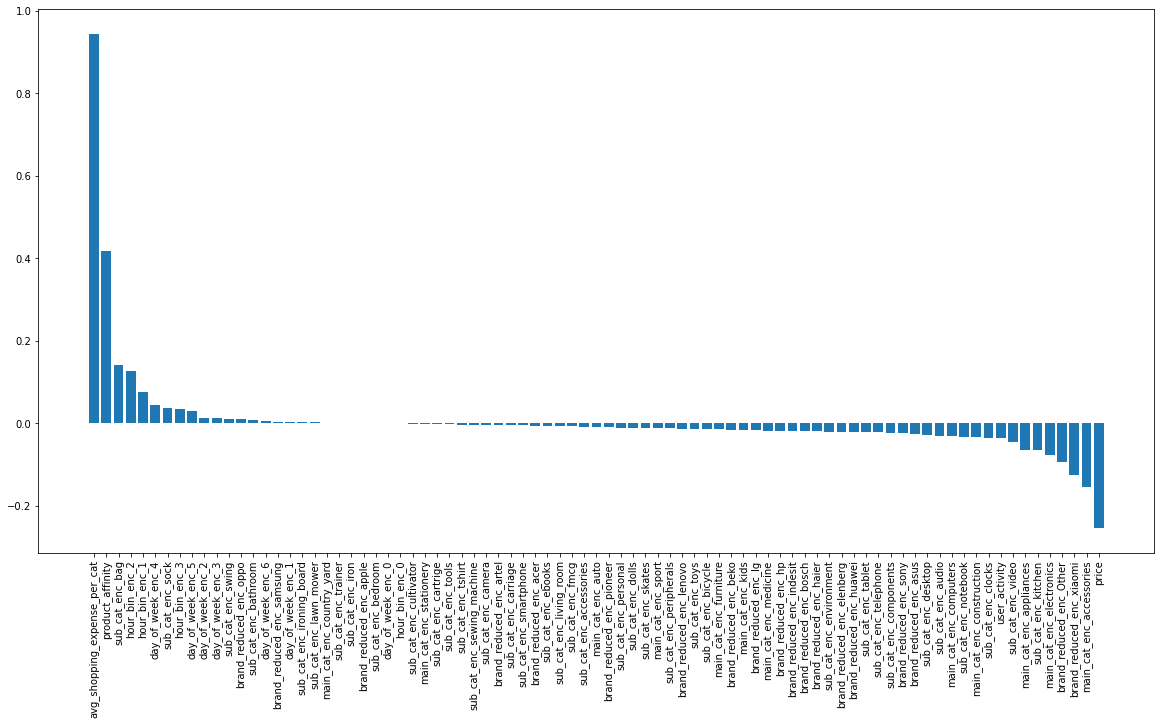

In [61]:
plt.figure(figsize=(20,10))
plt.xticks(rotation=90)
plt.bar(data=featureImp,x='name',height='score')

#### Updated model, if any
Repeat the steps 